In [3]:
import numpy as np
from numpy import random
from sklearn.metrics import precision_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math
from functions_2 import LoadBatch, montage 

In [43]:
def separete_file(filename):
    data = filename[b'data']
    labels = filename[b'labels']
    y=np.array(filename[b'labels'])#(10000,)
    one_hot = np.zeros((len(y), 10), dtype=int)
    one_hot[np.arange(len(y)), y] = 1 #(10000,10)
    
    return np.transpose(y), np.transpose(one_hot), np.transpose(data)

def normalize(data, column_means, column_stds):# we want to normalize train, val, and test with the training parameters.
    column_means = data.mean(axis=0)#in all cases we normalize with the training set mean
    column_stds = data.std(axis=0)#and training set sd
    data = data - column_means
    data = data / column_stds
    return data

def init_parameters(mean, size):
    std = np.sqrt( 1 / size.shape[1] )
    return random.normal(mean, std, size)#L1: W(m=number of hidden nodes x d=number of inputs), b = (m x 1)
                                         #L2: W(K=number of classes x m), b = (K x 1)
    

def ComputeAccuracy(X, y, W1, b1, W2, b2):
    P, _ = EvaluateClassifier(X, W1, b1, W2, b2)
    estimated_y = np.argmax(P, axis=0)
    accurancy = accuracy_score(y, estimated_y)
    return accurancy

    
def EvaluateClassifier(X, W1, b1, W2, b2):
    s1 = np.dot(W1,X)+ b1
    s1[s1 <= 0] = 0 #ReLu activation function
    s = np.dot(W2,s1)+ b2
    P = np.exp(s)/np.sum(np.exp(s), axis=0)
    return P, s1

def ComputeCost(X, Y, W1, b1, W2, b2, lambd):
    P, _ = EvaluateClassifier(X, W1, b1, W2, b2)
    regulaizer = lambd*(np.sum(np.square(W1)) + np.sum(np.square(W2)))
    N = X.shape[1]
    square_matrix = np.multiply(Y, np.log(P))
    sum_diag = -np.sum(square_matrix) 
    cost = (1/N) * sum_diag + regulaizer
    return cost

def ComputeGradients(X, Y, W1, b1, W2, b2, lambd, P , h):
    G_batch = -(Y - P)
    N = X.shape[1]
    grad_W2 = np.add(np.dot(G_batch,np.transpose(h)) / N , 2*lambd*W2)
    grad_b2 = np.dot(G_batch,np.ones((h.shape[1],1))) / N
    G_batch = np.dot(np.transpose(W2), G_batch)
    G_batch = np.multiply(G_batch, h>0)
    grad_W1 = np.add(np.dot(G_batch,np.transpose(X)) / N , 2*lambd*W1)
    grad_b1 = np.dot(G_batch,np.ones((X.shape[1],1))) / N
    return grad_W1, grad_b1, grad_W2, grad_b2


def MiniBatchGD_CLR(X, Y, y, X_val, Y_val, y_val, n_batch, eta, n_epochs, W1, b1, W2, b2, lambd, n_s, p,CLR_bool = False,
                   drop_out = False):
    N = X.shape[1]
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    etas = []
    
    for epoch in range(n_epochs):
    
        for batch in range(0, N, n_batch): 
            
            P, h = EvaluateClassifier(X[:,batch:batch+n_batch], W1, b1, W2, b2)
            if drop_out:
                u1 = [random.randint(0,100) for i in range(p)]
                h[u1] = 0
            
            grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X[:,batch:batch+n_batch], Y[:,batch:batch+n_batch], 
                                                                  W1, b1, W2, b2, lambd, P, h)
            if CLR_bool:
                eta = CLR(epoch, batch, N, n_batch, 1e-5, 1e-1, n_s)
                etas.append(eta)
            
            W1 -= eta*grad_W1
            b1 -= eta*grad_b1
            W2 -= eta*grad_W2
            b2 -= eta*grad_b2
            
        train_acc.append(ComputeAccuracy(X, y, W1, b1, W2, b2))
        train_loss.append(ComputeCost(X, Y, W1, b1, W2, b2, lambd))

        val_acc.append(ComputeAccuracy(X_val, y_val, W1, b1, W2, b2))
        val_loss.append(ComputeCost(X_val, Y_val, W1, b1, W2, b2, lambd))
        
    return W1, b1, W2, b2, train_acc, train_loss, val_acc, val_loss, etas


def CLR(epoch, batch, N, n_batch, eta_min, eta_max, n_s): 
    iterCounter = list(range(0, N, n_batch)).index(batch) + (epoch*n_batch) #current iteration--> time t.  
    cycle = math.floor(iterCounter/(2 * n_s)) #current cycle --> current 'trinagle' 
    
    if iterCounter >= 2*n_s*cycle and iterCounter < (2*cycle + 1)*n_s:#if t is located in the first half of the triangle
        eta = eta_min + ((iterCounter - 2*n_s*cycle)*(eta_max - eta_min) / n_s)
        
    elif iterCounter >= (2*cycle + 1)*n_s and iterCounter < 2*(cycle + 1)*n_s:#if t is located in the second half of the triangle
        eta = eta_max - ((iterCounter - (2*cycle+1)*n_s)*(eta_max - eta_min) / n_s)
        
    return eta

def grid_search(X, Y, y, X_val, Y_val, y_val, n_batch, eta, n_epochs, W1, b1, W2, b2, lambdas, n_s):

    grid_search_array = pd.DataFrame({'lambda':[], 'valid_accurancy':[]})
    for lambd in lambdas:

        _, _, _, _,train_acc, train_loss, val_acc, val_loss, _ =MiniBatchGD_CLR(X, Y, y, X_val, Y_val, y_val,n_batch,
                                                                   eta, n_epochs, W1, b1, W2, b2, lambd, 
                                                                   n_s,CLR_bool = True)
        
        grid_search_array = grid_search_array.append({'lambda':lambd, 'valid_accurancy':max(val_acc)}, ignore_index=True)
        
    grid_search_array.sort_values(['valid_accurancy'], inplace=True)
    return grid_search_array


def plot_loss(train_loss, val_loss, size):
    plt.plot(train_loss, label='train loss= '+str(round(max(train_loss), 3))+',h-nodes: '+str(size), linestyle = '--')
    plt.plot(val_loss,label='validation loss= '+str(round(max(val_loss), 3))+',h-nodes: '+str(size))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title('Loss function')
    #plt.show()
    
def plot_accurancy(train_acc, val_acc, size):
    plt.plot(train_acc, label='train acc= '+str(round(max(train_acc), 3))+',h-nodes: '+str(size), linestyle = '--')
    plt.plot(val_acc,label='validationtrain acc= '+str(round(max(val_acc), 3))+',h-nodes: '+str(size))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accurancy")
    plt.title('Accurancy function')
    #plt.show()

In [4]:
batch1 = LoadBatch('data_batch_1')
batch2 = LoadBatch('data_batch_2')
batch3 = LoadBatch('data_batch_3')
batch4 = LoadBatch('data_batch_4')
batch5 = LoadBatch('data_batch_5')
test = LoadBatch('test_batch')

y_train1,one_hot_train1,images_train1=separete_file(batch1)
y_train2,one_hot_train2,images_train2=separete_file(batch2)
y_train3,one_hot_train3,images_train3=separete_file(batch3)
y_train4,one_hot_train4,images_train4=separete_file(batch4)
y_train5,one_hot_train5,images_train5=separete_file(batch5)
y_test,one_hot_test,images_test=separete_file(test)

#Concatenate the five batch files to get the entire dataset
CIFAR10 = np.concatenate((images_train1, images_train2, images_train3, images_train4, images_train5), axis = 1)#3072x50000
LABELS = np.concatenate((y_train1, y_train2, y_train3, y_train4, y_train5), axis = 0)#50000,1
ONE_HOT = np.concatenate((one_hot_train1, one_hot_train2, one_hot_train3, one_hot_train4, one_hot_train5), axis = 1)#10x50000


# Subset the validation set
np.random.seed(0)
indexes_validation = np.random.choice(range(CIFAR10.shape[1]), 5000, replace=False)
CIFAR10_val = CIFAR10[:,indexes_validation]
ONE_HOT_val = ONE_HOT[:,indexes_validation]#10x5000
LABELS_val = [LABELS[i] for i in indexes_validation]#5000x1

# Subset the training set
CIFAR10_train = np.delete(CIFAR10, indexes_validation, 1)
ONE_HOT_train = np.delete(ONE_HOT, indexes_validation, 1)#10x45000
LABELS_TRAIN = [LABELS[i] for i in range(CIFAR10.shape[1]) if i not in indexes_validation]#45000x1

#Normalize the train, val, and test data with the train's means and standard deviations
column_means = CIFAR10_train.mean(axis=0)#train's means
column_stds = CIFAR10_train.std(axis=0)#train's stds
CIFAR10_train_norm = normalize(CIFAR10_train, column_means, column_stds)#3072x45000
CIFAR10_val_norm = normalize(CIFAR10_val, column_means, column_stds)#3072x5000
CIFAR10_test_norm = normalize(images_test, column_means, column_stds)#3072x10000

#### 1.a Explore whether having significantly more hidden nodes improves the final classification rate

In [31]:
d = CIFAR10_train_norm.shape[0]
K = ONE_HOT_train.shape[0]
hidden_size = [50, 100, 150, 200]
n_s = 2 * np.floor(CIFAR10_train_norm.shape[1] / 100)
train_acc_list = []
train_loss_list = []
valid_acc_list = []
valid_loss_list = []
for m in hidden_size:
    best_lambda = 0.0065 * (m / 50)    #make lambda proportional to biggher hidden layers
    sd1 = np.sqrt(1/d)                 #sd to initialize W1
    sd2 = np.sqrt(1/m)                 ##sd to initialize W2
    W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
    b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
    W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
    b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer
    W1_, b1_, W2_, b2_, train_acc, train_loss, valid_acc, valid_loss, etas  = MiniBatchGD_CLR(CIFAR10_train_norm, 
                                                                           ONE_HOT_train, LABELS_TRAIN, 
                                                                           CIFAR10_val_norm, ONE_HOT_val, LABELS_val,
                                                                           100, 0.001, 69, W1, b1, W2, b2, best_lambda,
                                                                           n_s, p = 0,
                                                                           CLR_bool=True, drop_out = False)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    valid_acc_list.append(valid_acc)
    valid_loss_list.append(valid_loss)
    
    print('with '+ str(m)+ ' hidden nodes we get a validation accurancy equal to: ' +str(max(valid_acc)))
    

with 50 hidden nodes we get a validation accurancy equal to: 0.5152
with 100 hidden nodes we get a validation accurancy equal to: 0.5196
with 150 hidden nodes we get a validation accurancy equal to: 0.5044
with 200 hidden nodes we get a validation accurancy equal to: 0.487


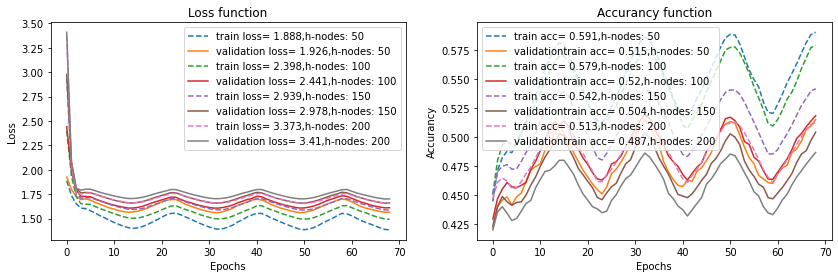

In [44]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
for i in range(len(valid_loss_list)):
    plot_loss(train_loss_list[i], valid_loss_list[i], (i+1)*50)
fig.add_subplot(122)
for j in range(len(train_acc_list)):
    plot_accurancy(train_acc_list[j], valid_acc_list[j], (j+1)*50)

#### 1.b Apply dropout to your training if you have a high number of hidden nodes and you feel you need more regularization.

In [13]:
d = CIFAR10_train_norm.shape[0]
K = ONE_HOT_train.shape[0]
m = 100
n_s = 2 * np.floor(CIFAR10_train_norm.shape[1] / 100)
best_lambda = 0.0065 * (m / 50)    #make lambda proportional to biggher hidden layers
sd1 = np.sqrt(1/d)                 #sd to initialize W1
sd2 = np.sqrt(1/m)                 ##sd to initialize W2
W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer

W1_, b1_, W2_, b2_, train_acc, train_loss, valid_acc, valid_loss, etas  = MiniBatchGD_CLR(CIFAR10_train_norm, 
                                                                       ONE_HOT_train, LABELS_TRAIN, 
                                                                       CIFAR10_val_norm, ONE_HOT_val, LABELS_val,
                                                                       100, 0.001, 69, W1, b1, W2, b2, best_lambda,
                                                                       n_s, p=30, CLR_bool=True, drop_out = True)

#### Dropout with propbability 0.3

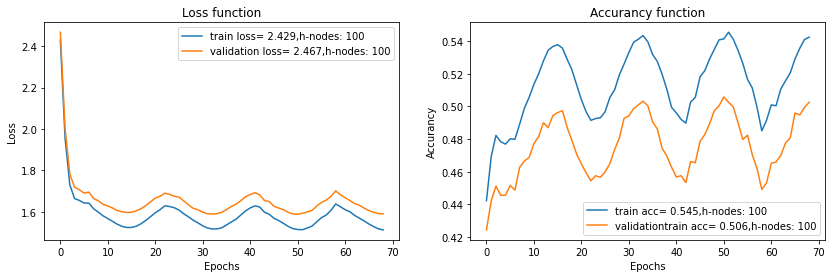

In [18]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss, 100)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc, 100)
    

In [19]:
d = CIFAR10_train_norm.shape[0]
K = ONE_HOT_train.shape[0]
m = 100
n_s = 2 * np.floor(CIFAR10_train_norm.shape[1] / 100)
best_lambda = 0.0065 * (m / 50)    #make lambda proportional to biggher hidden layers
sd1 = np.sqrt(1/d)                 #sd to initialize W1
sd2 = np.sqrt(1/m)                 ##sd to initialize W2
W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer

W1_, b1_, W2_, b2_, train_acc, train_loss, valid_acc, valid_loss, etas  = MiniBatchGD_CLR(CIFAR10_train_norm, 
                                                                       ONE_HOT_train, LABELS_TRAIN, 
                                                                       CIFAR10_val_norm, ONE_HOT_val, LABELS_val,
                                                                       100, 0.001, 69, W1, b1, W2, b2, best_lambda,
                                                                       n_s, p=50, CLR_bool=True, drop_out = True)

#### Dropout with propbability 0.4

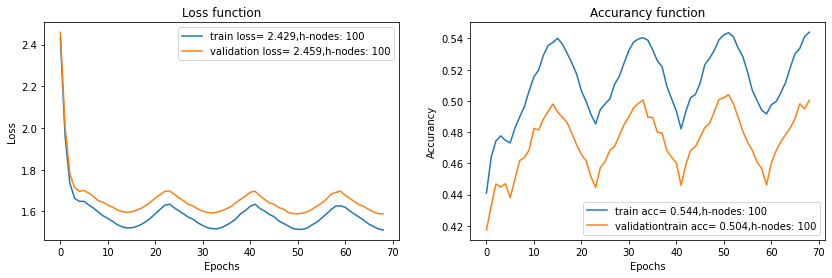

In [20]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss, 100)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc, 100)

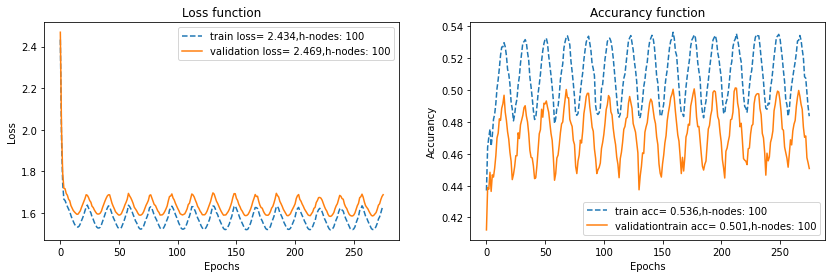

In [45]:
d = CIFAR10_train_norm.shape[0]
K = ONE_HOT_train.shape[0]
m = 100
n_s = 2 * np.floor(CIFAR10_train_norm.shape[1] / 100)
best_lambda = 0.0065 * (m / 50)    #make lambda proportional to biggher hidden layers
sd1 = np.sqrt(1/d)                 #sd to initialize W1
sd2 = np.sqrt(1/m)                 ##sd to initialize W2
W1 = random.normal(0, sd1, (m, d)) #initialize weight matrix, input layer
b1 = random.normal(0, 0, (m, 1))   #initialize bias vector, input layer
W2 = random.normal(0, sd2, (K, m)) #initialize weight matrix, hidden layer
b2 = random.normal(0, 0, (K, 1))   #initialize bias vector, hidden layer

W1_, b1_, W2_, b2_, train_acc, train_loss, valid_acc, valid_loss, etas  = MiniBatchGD_CLR(CIFAR10_train_norm, 
                                                                       ONE_HOT_train, LABELS_TRAIN, 
                                                                       CIFAR10_val_norm, ONE_HOT_val, LABELS_val,
                                                                       100, 0.001, 69*4, W1, b1, W2, b2, best_lambda,
                                                                       n_s, p=40, CLR_bool=True, drop_out = True)

fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss, 100)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc, 100)